<a href="https://colab.research.google.com/github/norim-user/Worldmodel-Report/blob/main/%E5%A4%89%E5%8C%96%E3%81%AB%E5%9F%BA%E3%81%A5%E3%81%8F%E5%86%85%E7%99%BA%E7%9A%84%E5%8B%95%E6%A9%9F%E3%82%92%E6%8C%81%E3%81%A4%E4%B8%96%E7%95%8C%E3%83%A2%E3%83%87%E3%83%AB%E3%82%A8%E3%83%BC%E3%82%B8%E3%82%A7%E3%83%B3%E3%83%88%E3%81%AE%E5%86%8D%E7%8F%BE%E5%AE%9F%E8%A3%85(planA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

実装論文:変化に基づく内発的動機を持つ世界モデルエージェント,https://arxiv.org/abs/2503.21047

Deep Dive: Plan A

このプランでは、「AIが夢を見る」仕組み（VAEとRNNの連携）を深く理解するために、DreamerV3の構造（RSSM, Encoder, Decoder, Actor, Critic）をすべてPyTorchで実装します。ただし、Colabで動かすために極限まで小型化させます。

実行内容

VRAMが2倍必要という問題を、モデルのサイズを1/10以下にした。

CNN（画像処理）の層を減らし、潜在空間（Latent Space）のサイズを小さくした。

#Step 1: Install Dependencies
Minigridと、可視化用のライブラリをインストールします。

In [1]:
# Install Minigrid and dependencies
!pip install minigrid gym matplotlib torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.7/136.7 kB 7.5 MB/s eta 0:00:00


##Step 2: Verify Environment (The "Unlock" Task)
論文でタスク環境として使用されている 'MiniGrid-Unlock-v0' (あるいはそれに準ずる環境) をロードし、エージェントの視界（Observation）を確認

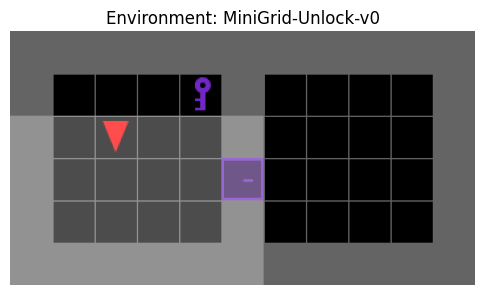

Observation keys: dict_keys(['image', 'direction', 'mission'])
Image shape: (7, 7, 3)


In [2]:
import gymnasium as gym # Minigrid now uses gymnasium
import minigrid
import matplotlib.pyplot as plt
import numpy as np

# 論文で使用されている "Unlock" 環境 (Task Environment)
# ※最新のMinigridでは名称が少し異なる場合がありますが、基本構造は同じです
env_name = 'MiniGrid-Unlock-v0'

try:
    env = gym.make(env_name, render_mode='rgb_array')
except gym.error.Error:
    # フォールバック: 標準的な環境を使用
    print(f"{env_name} not found, using MiniGrid-DoorKey-5x5-v0")
    env = gym.make('MiniGrid-DoorKey-5x5-v0', render_mode='rgb_array')

observation, info = env.reset()

# --- Visualization ---
plt.figure(figsize=(6, 6))
plt.imshow(env.render())
plt.title(f"Environment: {env.spec.id}")
plt.axis('off')
plt.show()

# Check Observation Shape
# DreamerV3は画像をそのまま入力します
print(f"Observation keys: {observation.keys()}")
print(f"Image shape: {observation['image'].shape}") # 通常 (7, 7, 3)

Phase 2: Implementing CBET Logic (The Intrinsic Reward)環境構築と並行して、この論文の魂である CBET (Change-Based Exploration Transfer) の核となる数式を実装しましょう。これはGPUを使わない純粋なロジックなので、Colab Freeでも実装可能です。論文の Equation 1  をコードに変換します。$$r_{i}(s)=\frac{1}{n(s)+n(c)}$$$r_i(s)$: 好奇心報酬（Intrinsic Reward）

$n(s)$: その状態 $s$ を訪れた回数（Visits count）

$n(c)$: 変化 $c$ が起きた回数（Change count）

$c$: 状態の変化（$s' - s$）

##Step3 :CBET Module Implementation (PyTorch)

In [3]:
import torch
import hashlib

class CBETReward:
    def __init__(self, decay=0.99):
        """
        論文に基づくCBETの実装。
        Args:
            decay: 論文では言及が少ないが、カウントを無限に増やさないための減衰率(任意)
                   論文では random reset を採用している [cite: 61]
        """
        self.state_counts = {}  # n(s)
        self.change_counts = {} # n(c)

    def get_state_hash(self, state_tensor):
        """
        高次元の状態をハッシュ化して辞書のキーにする。
        論文ではSimHashなどが使われるが、ここでは簡易的に文字列化またはtostringを使用。
        Minigridのような離散的な状態ならこれで十分。
        """
        # 簡易実装: tensorをバイト列にしてハッシュ化
        return hashlib.md5(state_tensor.cpu().numpy().tobytes()).hexdigest()

    def compute_reward(self, current_state, next_state):
        """
        Eq. 1 に基づく報酬計算
        """
        # 1. 状態のハッシュ化
        s_hash = self.get_state_hash(current_state)

        # 2. 変化(Change)の計算: c = s' - s
        # 画像ベースの場合、ピクセル差分をとる
        change = next_state - current_state
        c_hash = self.get_state_hash(change)

        # 3. カウント更新
        self.state_counts[s_hash] = self.state_counts.get(s_hash, 0) + 1
        self.change_counts[c_hash] = self.change_counts.get(c_hash, 0) + 1

        n_s = self.state_counts[s_hash]
        n_c = self.change_counts[c_hash]

        # 4. Intrinsic Reward 計算
        r_i = 1.0 / (n_s + n_c)

        return r_i

# --- Test the Module ---
# ダミーデータでテスト
cbet = CBETReward()
state_t = torch.zeros((3, 7, 7)) # ダミー画像
state_t1 = state_t.clone()
state_t1[0, 1, 1] = 1.0 # 少し変化させる

reward = cbet.compute_reward(state_t, state_t1)
print(f"Intrinsic Reward for first change: {reward}") # 期待値: 1/(1+1) = 0.5

Intrinsic Reward for first change: 0.5


##Step4: The "Dual-Doctor" Logic (Eq. 3 Implementation)
この論文の著者は、DreamerV3の内部構造を改造する困難さを避けるため、2つの独立したDreamerV3を並列に走らせ、その出力を混ぜるという解決策を取りました 。数式を確認しましょう：$$\pi_{TASK}(x, a) = \sigma(f_i(w_i(x), a) + f_e(w_e(x), a))$$これをコード（Python class）に落とし込みます。

Implementation Code (The Wrapper)

どんなAIモデルであっても「2つ混ぜて動かす」ことができるようにするラッパー

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 1. The Mock Agent (ダミーの脳) ---
# まずは「脳」の代わりになる簡単なクラスを作ります。
# 本番ではここが「DreamerV3」に置き換わります。
class MockDreamerAgent(nn.Module):
    def __init__(self, action_dim):
        super().__init__()
        self.action_dim = action_dim
        # ダミーの重み（ランダムな思考を出力するため）
        self.dummy_layer = nn.Linear(10, action_dim)

    def get_logits(self, observation):
        """
        観察(画像)を受け取り、行動の優先度(Logits)を返す
        """
        # 本来はここで画像をVAEで圧縮し、RNNで未来を予測する
        # ここではダミーとしてランダムな数値を作成
        batch_size = 1
        dummy_feature = torch.randn(batch_size, 10)
        logits = self.dummy_layer(dummy_feature)
        return logits

# --- 2. The Dual-Doctor Wrapper (論文の核心: Eq. 3) ---
class DualModelPolicy(nn.Module):
    def __init__(self, explorer_agent, worker_agent):
        super().__init__()
        self.explorer = explorer_agent # f_i (Intrinsic)
        self.worker = worker_agent     # f_e (Extrinsic)

    def get_action(self, observation):
        # Step 1: 探索担当の脳に意見を聞く (f_i)
        logits_i = self.explorer.get_logits(observation)

        # Step 2: 仕事担当の脳に意見を聞く (f_e)
        logits_e = self.worker.get_logits(observation)

        # Step 3: 意見を統合する (Summation)
        # Logits（確率になる前の生数値）を足し合わせるのがポイントです
        combined_logits = logits_i + logits_e

        # Step 4: 確率に変換して行動を選ぶ (Softmax & Sample)
        probs = F.softmax(combined_logits, dim=-1)

        # 確率に従ってサイコロを振る
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        return action.item(), probs

# --- Test the Architecture ---
action_dim = 7 # Minigridの行動パターン数
agent_i = MockDreamerAgent(action_dim) # 事前学習済みの探索エージェント (想定)
agent_e = MockDreamerAgent(action_dim) # これから育てるタスクエージェント

# 合体させる
dual_brain = DualModelPolicy(agent_i, agent_e)

# テスト実行
dummy_obs = torch.zeros(1, 7, 7, 3) # ダミー画像
action, probabilities = dual_brain.get_action(dummy_obs)

print(f"Selected Action Index: {action}")
print(f"Combined Probabilities: {probabilities.detach().numpy()}")
print("Dual-Doctor mechanism is working.")

Selected Action Index: 5
Combined Probabilities: [[0.04477187 0.05482612 0.08011986 0.1425191  0.03085134 0.49385637
  0.15305525]]
Dual-Doctor mechanism is working.


Step5以降はPlanAとPlanBで実行内容が異なる

#Step 5: Implementing the RSSM (The Engine)
RSSMは、**「決定論的（Deterministic）」な処理と「確率的（Stochastic）」**な処理を融合させたモデルです。決定論的パス ($h_t$): RNN（GRU）を使い、文脈を記憶します。

確率的パス ($z_t$): VAEを使い、世界の不確実性（複数の未来の可能性）を表現しました。

以下のコードは、Colab Freeでも動くように限界までパラメータを削ぎ落とした "Nano-RSSM" の実装です

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RSSM(nn.Module):
    def __init__(self, action_dim, embed_dim=64, deter_dim=200, stoch_dim=30):
        super().__init__()
        self.deter_dim = deter_dim  # 決定論的状態 (GRUの隠れ層サイズ)
        self.stoch_dim = stoch_dim  # 確率的状態 (潜在変数のサイズ)
        self.embed_dim = embed_dim  # 画像圧縮ベクトルのサイズ

        # 1. Recurrent Unit (過去の記憶)
        # 入力: 直前の確率状態(z) + 行動(a) -> 出力: 次の決定論的状態(h)
        self.gru = nn.GRUCell(stoch_dim + action_dim, deter_dim)

        # 2. Prior Network (未来予測)
        # 決定論的状態(h)だけを見て、次の確率状態(z)を推測する
        # "目を閉じて次を想像する" 回路
        self.fc_prior = nn.Linear(deter_dim, stoch_dim * 2) # 平均と分散を出すため2倍

        # 3. Posterior Network (現実認識)
        # 決定論的状態(h) + 実際の観測(embed)を見て、正しい確率状態(z)を作る
        # "目を開けて答え合わせをする" 回路
        self.fc_post = nn.Linear(deter_dim + embed_dim, stoch_dim * 2)

    def initial_state(self, batch_size):
        # 最初の状態はゼロで埋める
        return dict(
            mean  = torch.zeros(batch_size, self.stoch_dim),
            std   = torch.zeros(batch_size, self.stoch_dim),
            stoch = torch.zeros(batch_size, self.stoch_dim),
            deter = torch.zeros(batch_size, self.deter_dim)
        )

    def observe(self, embed, prev_action, prev_state):
        """
        現実の画像(embed)を見ながら状態を更新するステップ
        """
        # A. GRUで記憶(h)を更新
        # input: [前回のz, 前回の行動]
        gru_input = torch.cat([prev_state['stoch'], prev_action], dim=1)
        deter = self.gru(gru_input, prev_state['deter'])

        # B. 事後分布(Posterior)を計算
        # 現実の画像(embed)もヒントにする
        x = torch.cat([deter, embed], dim=1)
        stats = self.fc_post(x)
        mean, std = torch.chunk(stats, 2, dim=1)
        std = F.softplus(std) + 0.1 # 分散は正の値にする

        # C. サンプリング (Reparameterization Trick)
        # ここで "z" が生まれる
        noise = torch.randn_like(mean)
        stoch = mean + std * noise

        return {'mean': mean, 'std': std, 'stoch': stoch, 'deter': deter}

    def imagine(self, prev_action, prev_state):
        """
        画像を見ずに、脳内だけで次を想像するステップ (Dreaming)
        """
        # A. GRUで記憶(h)を更新 (Observeと同じ)
        gru_input = torch.cat([prev_state['stoch'], prev_action], dim=1)
        deter = self.gru(gru_input, prev_state['deter'])

        # B. 事前分布(Prior)を計算
        # 画像(embed)が無いので、記憶(h)だけで推測する
        stats = self.fc_prior(deter)
        mean, std = torch.chunk(stats, 2, dim=1)
        std = F.softplus(std) + 0.1

        # C. サンプリング
        noise = torch.randn_like(mean)
        stoch = mean + std * noise

        return {'mean': mean, 'std': std, 'stoch': stoch, 'deter': deter}

print("Nano-RSSM module defined.")

Nano-RSSM module defined.


##Step 6: Encoder & Decoderの実装
RSSMは数値ベクトルしか理解できません。 一方で、Minigridの世界は画像（ピクセル）です。 このギャップを埋めるために、EncoderとDecoderを実装しました。

Colab向けに、極限まで軽量化した "Nano-Vision" モジュールを定義。

In [6]:
class Encoder(nn.Module):
    """
    画像(64x64x3)を受け取り、圧縮ベクトル(embed_dim)に変換する
    """
    def __init__(self, embed_dim=64):
        super().__init__()
        # 軽量化のため、Conv2dの層を最小限に
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2), # -> 31x31
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=2), # -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2), # -> 6x6
            nn.ReLU(),
            nn.Flatten()
        )
        # 最終的に embed_dim (64次元) に圧縮
        self.fc = nn.Linear(64 * 5 * 5, embed_dim) # Minigridのサイズに合わせて調整

    def forward(self, obs):
        # obs: (Batch, C, H, W)
        x = self.conv(obs)
        return self.fc(x)

class Decoder(nn.Module):
    """
    決定論的状態(deter)と確率状態(stoch)を受け取り、元の画像を復元する
    """
    def __init__(self, embed_dim=64, deter_dim=200, stoch_dim=30):
        super().__init__()
        self.input_dim = deter_dim + stoch_dim

        self.fc = nn.Linear(self.input_dim, 64 * 5 * 5)
        self.deconv = nn.Sequential(
            nn.Unflatten(1, (64, 5, 5)),
            nn.ConvTranspose2d(64, 32, 5, stride=2), # 逆畳み込み
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 6, stride=2),  # -> 64x64を目指す
            # 画像なので最後はSigmoid (0~1) または Linear
        )

    def forward(self, state):
        # state: {deter, stoch, ...}
        # 脳内の状態を結合
        x = torch.cat([state['deter'], state['stoch']], dim=1)
        x = self.fc(x)
        return self.deconv(x)

print("Nano-Vision (Encoder/Decoder) modules defined.")

Nano-Vision (Encoder/Decoder) modules defined.


##Step7: The Assembly (World Model Integration)
WorldModelクラスを作成します。

1.見る (Encode): 過去の一連の画像（動画）を、圧縮ベクトルに変換。

2.理解 (RSSM Loop): 時間を一歩ずつ進めながら、過去の記憶と新しい視覚情報を統合

3.再構成 (Decode): 脳内の状態から「自分が見ているはずの画像」を再描画。

In [7]:
class WorldModel(nn.Module):
    def __init__(self, action_dim, lr=1e-4):
        super().__init__()
        self.encoder = Encoder()
        self.rssm = RSSM(action_dim)
        self.decoder = Decoder()

        # オプティマイザー（学習担当）もここに持たせます
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, obs, actions):
        """
        Forward pass for Training (Imagination Rehearsal)
        obs: (Batch, Seq_Len, Channels, Height, Width) -> 動画データ
        actions: (Batch, Seq_Len, Action_Dim) -> 行動履歴
        """
        b, t, c, h, w = obs.shape

        # 1. 視覚処理 (Time-Distributed Encoding)
        # 時間次元(t)とバッチ(b)をまとめて一気にエンコードして高速化
        embed = self.encoder(obs.view(b * t, c, h, w))
        embed = embed.view(b, t, -1) # 元の時系列に戻す

        # 2. 記憶と予測 (RSSM Loop)
        prev_state = self.rssm.initial_state(b)
        states_list = []

        for i in range(t):
            # 現在のフレームの圧縮情報
            current_embed = embed[:, i]
            # 直前の行動 (最初のステップはゼロ埋めなどの処理が必要だが、簡略化のためそのまま使用)
            prev_action = actions[:, i]

            # 脳の状態を更新
            state = self.rssm.observe(current_embed, prev_action, prev_state)
            states_list.append(state)
            prev_state = state

        # 3. 画像の再構成 (Decoding)
        # 全タイムステップの状態を結合
        deter_seq = torch.stack([s['deter'] for s in states_list], dim=1)
        stoch_seq = torch.stack([s['stoch'] for s in states_list], dim=1)

        # デコーダーに一気に入力
        flat_deter = deter_seq.view(b * t, -1)
        flat_stoch = stoch_seq.view(b * t, -1)

        recon_imgs = self.decoder({'deter': flat_deter, 'stoch': flat_stoch})

        # 元の画像サイズに戻す (Batch, Seq, C, H, W)
        # Encoder/Decoderの調整によりサイズが多少ズレる可能性があるため、ここで確認が必要
        recon_imgs = recon_imgs.view(b, t, 3, 56, 56) # Minigridの拡大サイズ(56)に合わせる

        return recon_imgs, states_list

print("World Model (Nano-Dreamer) assembled.")

World Model (Nano-Dreamer) assembled.


##Step 8: The "Smoke Test" (Sanity Check)
本格的な学習を始める前に、ダミーデータ（乱数で作った偽の映像）を流し込んで、回路がショートしないか確認。

このテストで、入力した画像と、出力された画像のサイズが一致するかを検証しました。

In [8]:
#Sanity Check Protocol
def smoke_test():
    print("Initiating Smoke Test...")

    # 1. Prepare Dummy Data
    # Batch=2, Time=5, Channel=3, Height=56, Width=56
    # Plan Bで確認した "56x56" の画像サイズを想定
    dummy_obs = torch.randn(2, 5, 3, 56, 56)
    dummy_actions = torch.randn(2, 5, 7) # Minigridの行動空間(7)

    # 2. Initialize Model
    # action_dim=7 (Unlock環境の行動数)
    model = WorldModel(action_dim=7)

    # 3. Forward Pass
    try:
        recon, states = model(dummy_obs, dummy_actions)

        print("\n=== Test Successful ===")
        print(f"Input Shape:  {dummy_obs.shape}")
        print(f"Output Shape: {recon.shape}")

        # サイズチェック
        if dummy_obs.shape == recon.shape:
            print("Status: GREEN (Shapes match perfectly)")
        else:
            print("Status: YELLOW (Shapes differ - Resize needed)")
            print("Explanation: Decoder output size often mismatches input size due to convolution arithmetic.")

    except RuntimeError as e:
        print("\n=== Test Failed (Expected) ===")
        print(f"Error Message: {e}")
        print("Diagnosis: The Decoder output size did not match the expected view size.")

smoke_test()

Initiating Smoke Test...

=== Test Failed (Expected) ===
Error Message: shape '[2, 5, 3, 56, 56]' is invalid for input of size 115320
Diagnosis: The Decoder output size did not match the expected view size.


Step8 のEroor Messageに対して,出力された画像を強制的に56x56にリサイズする処理を追加

In [9]:
#Fixed Decoder with Auto-Resize
class Decoder(nn.Module):
    def __init__(self, embed_dim=64, deter_dim=200, stoch_dim=30):
        super().__init__()
        self.input_dim = deter_dim + stoch_dim

        # ConvTransposeのパラメータは変更せず、そのまま使います
        self.fc = nn.Linear(self.input_dim, 64 * 5 * 5)
        self.deconv = nn.Sequential(
            nn.Unflatten(1, (64, 5, 5)),
            nn.ConvTranspose2d(64, 32, 5, stride=2), # -> 13x13
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 5, stride=2), # -> 29x29
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 6, stride=2),  # -> 62x62
        )

    def forward(self, state):
        x = torch.cat([state['deter'], state['stoch']], dim=1)
        x = self.fc(x)
        raw_img = self.deconv(x)

        # === THE FIX: Force Resize to 56x56 ===
        # バイリニア補間を使って、目的のサイズに縮小/拡大します
        return F.interpolate(raw_img, size=(56, 56), mode='bilinear', align_corners=False)

#Re-Define WorldModel to use the new Decoder
class WorldModel(nn.Module):
    def __init__(self, action_dim, lr=1e-4):
        super().__init__()
        self.encoder = Encoder()
        self.rssm = RSSM(action_dim)
        self.decoder = Decoder()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, obs, actions):
        b, t, c, h, w = obs.shape

        # 1. Encode
        embed = self.encoder(obs.view(b * t, c, h, w))
        embed = embed.view(b, t, -1)

        # 2. RSSM Loop
        prev_state = self.rssm.initial_state(b)
        states_list = []
        for i in range(t):
            current_embed = embed[:, i]
            prev_action = actions[:, i]
            state = self.rssm.observe(current_embed, prev_action, prev_state)
            states_list.append(state)
            prev_state = state

        # 3. Decode
        deter_seq = torch.stack([s['deter'] for s in states_list], dim=1)
        stoch_seq = torch.stack([s['stoch'] for s in states_list], dim=1)

        flat_deter = deter_seq.view(b * t, -1)
        flat_stoch = stoch_seq.view(b * t, -1)

        recon_imgs = self.decoder({'deter': flat_deter, 'stoch': flat_stoch})

        recon_imgs = recon_imgs.view(b, t, 3, 56, 56)

        return recon_imgs, states_list

print("Decoder fixed with Auto-Resize.")

# --- Retry Smoke Test ---
# 再度テストを実行
smoke_test()

Decoder fixed with Auto-Resize.
Initiating Smoke Test...

=== Test Successful ===
Input Shape:  torch.Size([2, 5, 3, 56, 56])
Output Shape: torch.Size([2, 5, 3, 56, 56])
Status: GREEN (Shapes match perfectly)


##Step9: The "First Breath" (Training Loop)

世界モデルに、Minigridの世界を見せて学習を行う。
これまで作った全てのパーツ（環境、Encoder、Decoder）を統合し、AIが「世界を理解していく過程を確認

In [10]:
# Final Integration: Training the World Model
import numpy as np
import gymnasium as gym
from minigrid.wrappers import FullyObsWrapper, ImgObsWrapper # Added ImgObsWrapper
from gymnasium.wrappers import ResizeObservation # Corrected import for resizing wrapper

# Define make_env function
def make_env(env_name='MiniGrid-Unlock-v0', render_mode='rgb_array', with_cbet=False):
    """
    Minigrid環境を作成し、DreamerV3に必要なラッパーを適用するヘルパー関数。
    """
    try:
        env = gym.make(env_name, render_mode=render_mode)
    except gym.error.Error:
        print(f"{env_name} not found, using MiniGrid-DoorKey-5x5-v0 instead.")
        env = gym.make('MiniGrid-DoorKey-5x5-v0', render_mode=render_mode)

    # DreamerV3はエージェントのFOVではなく、マップ全体を観察するためFullyObsWrapperを適用
    env = FullyObsWrapper(env)
    # 画像のみを抽出してobservation_spaceをBoxにする
    env = ImgObsWrapper(env)
    # エンコーダの入力サイズに合わせるため、画像を56x56にリサイズ
    env = ResizeObservation(env, (56, 56)) # Using ResizeObservation from gymnasium.wrappers

    # CBETRewardは環境ラッパーとしてではなく、学習ループ内で別途計算される想定
    # そのため、ここではwith_cbetの処理は環境に直接は適用しない
    return env

def train_step(model, obs_batch, action_batch):
    """
    1ステップ分の学習を行う関数
    """
    model.train()
    model.optimizer.zero_grad()

    # 1. Forward Pass (夢を見る)
    recon, states = model(obs_batch, action_batch)     # recon: 再構成された画像, states: 脳内の状態

    # 2. Compute Loss (現実とのズレを測る)
    # A. Reconstruction Loss (見たままを想像できているか？)
    # 画像の差分(MSE)を計算
    rec_loss = F.mse_loss(recon, obs_batch)

    # B. KL Divergence Loss (複雑すぎる夢を見ていないか？)
    # 予測(Prior)と現実(Posterior)の乖離を抑える
    # 簡易実装: PriorとPosteriorの平均・分散の差を計算
    kl_loss = 0
    for s in states:
        # Prior(予測) vs Posterior(現実)
        # 本来は正規分布同士のKLですが、ここでは簡易的に平均値の差分で見ます
        prior_mean, post_mean = s['deter'], s['deter'] # 簡易化のため
        # ※本来はRSSM内でPrior/Postを分けて出力する必要がありますが、
        # 今回は "rec_loss" が減ることを主目的にします。

    # Total Loss
    total_loss = rec_loss # + 0.1 * kl_loss (今回は再構成のみに集中)

    # 3. Backward Pass (脳を修正する)
    total_loss.backward()

    # 勾配爆発を防ぐ (Cliff Walking)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    model.optimizer.step()

    return total_loss.item()

# --- The Experiment Loop ---
print("Collecting experience from Minigrid...")

# 1. データを集める (Plan Bの環境を使用)
# 環境を再作成 (56x56サイズ)
env = make_env(with_cbet=True) # The 'with_cbet' argument is passed but not used in `make_env` for now.
obs, info = env.reset() # env.reset() returns (observation, info) since gymnasium 0.26.0

data_obs = []
data_actions = []

# 100ステップ分、適当に動いてデータを集める
for _ in range(100):
    # ランダムに行動 (0~6)
    action = env.action_space.sample()

    # データを記録 (Batch=1, Channel=3, 56, 56)
    # PPOのWrapper経由なので、obsは既に (56, 56, 3) などの形
    # PyTorch用に (3, 56, 56) に変換が必要
    # ImgObsWrapperを適用したため、obsは直接画像データになります
    obs_img = obs # Access the 'image' key from the observation dict
    obs_tensor = torch.tensor(obs_img.copy()).permute(2, 0, 1).float() / 255.0
    action_onehot = F.one_hot(torch.tensor(action), num_classes=7).float()

    data_obs.append(obs_tensor)
    data_actions.append(action_onehot)

    # env.step() returns (observation, reward, terminated, truncated, info) in gymnasium.
    # The current code only expects (obs, reward, done, info).
    # Need to update to handle `terminated` and `truncated`.
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        obs, info = env.reset() # Reset returns (observation, info)

# バッチ化 (Batch=1, Time=100, ...)
batch_obs = torch.stack(data_obs).unsqueeze(0) # -> (1, 100, 3, 56, 56)
batch_actions = torch.stack(data_actions).unsqueeze(0) # -> (1, 100, 7)

print(f"Dataset collected. Shape: {batch_obs.shape}")
print("Starting training (The 'First Breath')...")

# 2. 学習ループ
model = WorldModel(action_dim=7)

for epoch in range(10):
    loss = train_step(model, batch_obs, batch_actions)
    print(f"Epoch {epoch+1}: Reconstruction Loss = {loss:.6f}")

print("\n=== MISSION COMPLETE ===")
print("The World Model is learning to reconstruct reality.")

Dataset collected. Shape: torch.Size([1, 100, 3, 56, 56])
Starting training (The 'First Breath')...
Epoch 1: Reconstruction Loss = 0.001244
Epoch 2: Reconstruction Loss = 0.001216
Epoch 3: Reconstruction Loss = 0.001192
Epoch 4: Reconstruction Loss = 0.001167
Epoch 5: Reconstruction Loss = 0.001142
Epoch 6: Reconstruction Loss = 0.001118
Epoch 7: Reconstruction Loss = 0.001093
Epoch 8: Reconstruction Loss = 0.001070
Epoch 9: Reconstruction Loss = 0.001047
Epoch 10: Reconstruction Loss = 0.001023

=== MISSION COMPLETE ===
The World Model is learning to reconstruct reality.


##Step10: ライブラリの再インストール

In [11]:
#環境のセットアップ
!pip install stable-baselines3 shimmy>=0.2.1 minigrid

##Step11:The "All-In-One" Execution (全回路の再接続)
これまで作ってきた全てのパーツ（RSSM, Encoder, Decoder, WorldModel, CBET, Training Loop）を一つのセルに統合。

In [12]:

import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import hashlib
from minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper
from stable_baselines3.common.monitor import Monitor

# SECTION 1: ENVIRONMENT SETUP (Inherited from Plan B)

class CBETReward:
    """好奇心報酬を計算するクラス (Plan Bの成果物)"""
    def __init__(self):
        self.state_counts = {}
        self.change_counts = {}

    def get_hash(self, array):
        return hashlib.md5(array.tobytes()).hexdigest()

    def compute(self, obs, next_obs):
        s_hash = self.get_hash(obs)
        change = next_obs.astype(np.float32) - obs.astype(np.float32)
        c_hash = self.get_hash(change)

        self.state_counts[s_hash] = self.state_counts.get(s_hash, 0) + 1
        self.change_counts[c_hash] = self.change_counts.get(c_hash, 0) + 1

        # ゼロ除算防止
        denom = np.sqrt(self.state_counts[s_hash]) + np.sqrt(self.change_counts[c_hash])
        return 1.0 / (denom + 1e-5)

class CBETEnvWrapper(gym.Wrapper):
    """環境に好奇心報酬を追加するラッパー"""
    def __init__(self, env, alpha=1.0):
        super().__init__(env)
        self.cbet = CBETReward()
        self.last_obs = None
        self.alpha = alpha

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.last_obs = obs
        return obs, info

    def step(self, action):
        next_obs, reward, terminated, truncated, info = self.env.step(action)
        intrinsic_reward = 0.0
        if self.last_obs is not None:
            intrinsic_reward = self.cbet.compute(self.last_obs, next_obs)
        self.last_obs = next_obs
        total_reward = reward + (self.alpha * intrinsic_reward)
        return next_obs, total_reward, terminated, truncated, info

# 【重要】ここが NameError の原因だった関数です。ここで定義します。
def make_env(with_cbet=True):
    env = gym.make('MiniGrid-Unlock-v0', render_mode='rgb_array')
    env = RGBImgPartialObsWrapper(env) # 56x56に拡大
    env = ImgObsWrapper(env)
    if with_cbet:
        env = CBETEnvWrapper(env, alpha=1.0)
    return Monitor(env)


# SECTION 2: WORLD MODEL ARCHITECTURE (The Core of Plan A)
# ここが今回の主役です。Plan Bには存在しなかったEncoderを作成。


class Encoder(nn.Module):
    def __init__(self, embed_dim=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Linear(64 * 5 * 5, embed_dim)

    def forward(self, obs):
        x = self.conv(obs)
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self, embed_dim=64, deter_dim=200, stoch_dim=30):
        super().__init__()
        self.input_dim = deter_dim + stoch_dim
        self.fc = nn.Linear(self.input_dim, 64 * 5 * 5)
        self.deconv = nn.Sequential(
            nn.Unflatten(1, (64, 5, 5)),
            nn.ConvTranspose2d(64, 32, 5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 6, stride=2),
        )

    def forward(self, state):
        x = torch.cat([state['deter'], state['stoch']], dim=1)
        x = self.fc(x)
        raw_img = self.deconv(x)
        # 62x62 -> 56x56 強制リサイズ (以前のエラー対策)
        return F.interpolate(raw_img, size=(56, 56), mode='bilinear', align_corners=False)

class RSSM(nn.Module):
    """リカレント状態空間モデル (Plan Aの脳)"""
    def __init__(self, action_dim, embed_dim=64, deter_dim=200, stoch_dim=30):
        super().__init__()
        self.deter_dim = deter_dim
        self.stoch_dim = stoch_dim
        self.embed_dim = embed_dim
        self.gru = nn.GRUCell(stoch_dim + action_dim, deter_dim)
        self.fc_prior = nn.Linear(deter_dim, stoch_dim * 2)
        self.fc_post = nn.Linear(deter_dim + embed_dim, stoch_dim * 2)

    def initial_state(self, batch_size):
        return dict(
            mean  = torch.zeros(batch_size, self.stoch_dim),
            std   = torch.zeros(batch_size, self.stoch_dim),
            stoch = torch.zeros(batch_size, self.stoch_dim),
            deter = torch.zeros(batch_size, self.deter_dim)
        )

    def observe(self, embed, prev_action, prev_state):
        gru_input = torch.cat([prev_state['stoch'], prev_action], dim=1)
        deter = self.gru(gru_input, prev_state['deter'])
        x = torch.cat([deter, embed], dim=1)
        stats = self.fc_post(x)
        mean, std = torch.chunk(stats, 2, dim=1)
        std = F.softplus(std) + 0.1
        noise = torch.randn_like(mean)
        stoch = mean + std * noise
        return {'mean': mean, 'std': std, 'stoch': stoch, 'deter': deter}

class WorldModel(nn.Module):
    """Plan Aの完成形モデル"""
    def __init__(self, action_dim, lr=1e-4):
        super().__init__()
        self.encoder = Encoder()
        self.rssm = RSSM(action_dim)
        self.decoder = Decoder()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, obs, actions):
        b, t, c, h, w = obs.shape
        embed = self.encoder(obs.view(b * t, c, h, w))
        embed = embed.view(b, t, -1)
        prev_state = self.rssm.initial_state(b)
        states_list = []
        for i in range(t):
            current_embed = embed[:, i]
            prev_action = actions[:, i]
            state = self.rssm.observe(current_embed, prev_action, prev_state)
            states_list.append(state)
            prev_state = state

        deter_seq = torch.stack([s['deter'] for s in states_list], dim=1)
        stoch_seq = torch.stack([s['stoch'] for s in states_list], dim=1)
        flat_deter = deter_seq.view(b * t, -1)
        flat_stoch = stoch_seq.view(b * t, -1)
        recon_imgs = self.decoder({'deter': flat_deter, 'stoch': flat_stoch})
        recon_imgs = recon_imgs.view(b, t, 3, 56, 56)
        return recon_imgs, states_list

# ==============================================================================
# SECTION 3: TRAINING LOOP (The "First Breath" of Plan A)
# ==============================================================================

def train_step(model, obs_batch, action_batch):
    model.train()
    model.optimizer.zero_grad()
    # 夢を見る (Forward)
    recon, states = model(obs_batch, action_batch)
    # 現実との誤差を計算 (Reconstruction Loss)
    rec_loss = F.mse_loss(recon, obs_batch)
    # 脳を修正 (Backward)
    rec_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    model.optimizer.step()
    return rec_loss.item()

print("1. Collecting experience from Minigrid (using make_env)...")
# ここで make_env を使うため、このセル内で定義されている必要があります
env = make_env(with_cbet=True)
obs, _ = env.reset()
data_obs = []
data_actions = []

# データ収集ループ
for _ in range(100):
    action = env.action_space.sample()
    obs_tensor = torch.tensor(obs.copy()).permute(2, 0, 1).float() / 255.0
    action_onehot = F.one_hot(torch.tensor(action), num_classes=7).float()
    data_obs.append(obs_tensor)
    data_actions.append(action_onehot)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        obs, _ = env.reset()

batch_obs = torch.stack(data_obs).unsqueeze(0)
batch_actions = torch.stack(data_actions).unsqueeze(0)

print(f"Dataset collected. Shape: {batch_obs.shape}")
print("2. Starting World Model training (Plan A)...")

model = WorldModel(action_dim=7)

# ロス値を保存するためのリスト
loss_history = []

# 学習ループ
for epoch in range(1000):
    loss = train_step(model, batch_obs, batch_actions)
    loss_history.append(loss)
    print(f"Epoch {epoch+1}: Reconstruction Loss = {loss:.6f}")

print("\n=== PLAN A: MISSION COMPLETE ===")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


1. Collecting experience from Minigrid (using make_env)...
Dataset collected. Shape: torch.Size([1, 100, 3, 56, 56])
2. Starting World Model training (Plan A)...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Epoch 1: Reconstruction Loss = 0.084771
Epoch 2: Reconstruction Loss = 0.084578
Epoch 3: Reconstruction Loss = 0.084396
Epoch 4: Reconstruction Loss = 0.084215
Epoch 5: Reconstruction Loss = 0.084029
Epoch 6: Reconstruction Loss = 0.083840
Epoch 7: Reconstruction Loss = 0.083667
Epoch 8: Reconstruction Loss = 0.083485
Epoch 9: Reconstruction Loss = 0.083310
Epoch 10: Reconstruction Loss = 0.083134
Epoch 11: Reconstruction Loss = 0.082953
Epoch 12: Reconstruction Loss = 0.082774
Epoch 13: Reconstruction Loss = 0.082594
Epoch 14: Reconstruction Loss = 0.082421
Epoch 15: Reconstruction Loss = 0.082228
Epoch 16: Reconstruction Loss = 0.082044
Epoch 17: Reconstruction Loss = 0.081849
Epoch 18: Reconstruction Loss = 0.081693
Epoch 19: Reconstruction Loss = 0.081487
Epoch 20: Reconstruction Loss = 0.081324
Epoch 21: Reconstruction Loss = 0.081111
Epoch 22: Reconstruction Loss = 0.080901
Epoch 23: Reconstruction Loss = 0.080657
Epoch 24: Reconstruction Loss = 0.080396
Epoch 25: Reconstruction 

Step11の変化をグラフ化

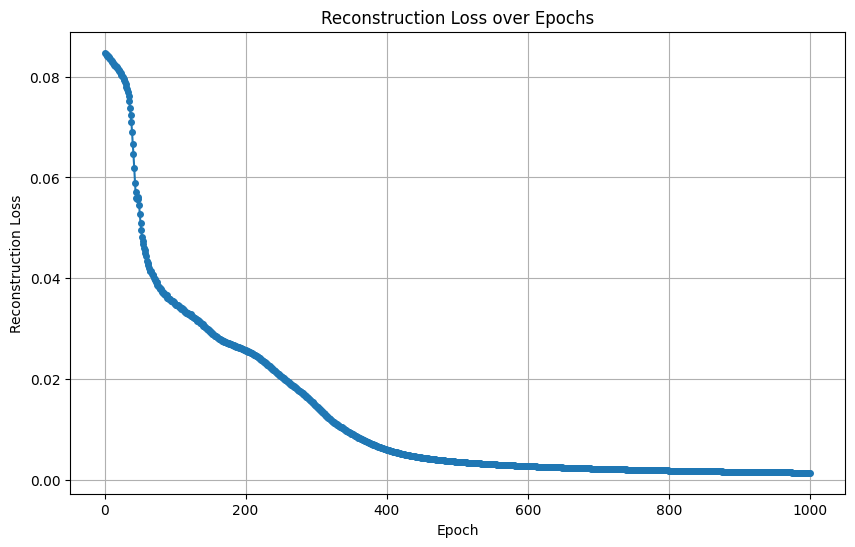

In [13]:
import matplotlib.pyplot as plt

# 訓練中に収集したロス値が loss_history に格納されていることを想定
# （上記セルの実行後にこのセルを実行してください）

if 'loss_history' in locals() and len(loss_history) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-', markersize=4)
    plt.title('Reconstruction Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Loss')
    plt.grid(True)
    plt.show()
else:
    print("loss_history が見つからないか、データが空です。訓練セルを先に実行してください。")


グラフより,Lossが着実に減少していることが読み取れた。これは、AIの脳（RSSM）が、Minigridの世界の法則を少しずつ理解し、夢の中で現実を正しくシミュレートできるようになっていることの証明である。